In [504]:
#Importing libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import missingpy

In [505]:
#Reading files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

test['Survived'] = 2 #Creating the target variable in test file in order to merge

df = pd.concat([train, test], ignore_index=True)

### EDA

In [506]:
profile = ProfileReport(df, explorative=True)
profile

### Missing data

Missing data has a higher impact in age and cabin variables. Let's impute only age (continuous variable) and then we will analyze if cabin variable worths to be imputed. 

In [507]:
df.Cabin.fillna('NA', inplace=True) # Fill the NA in Cabin column

In [508]:
X = df.drop(['Name', 'Ticket','Cabin'], axis=1) #Columns with a lot of different values aren't useful for imputation
X.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')

In [509]:
X = pd.get_dummies(X) # Dummy variables to convert to numeric variables


In [510]:
#Imputation
from missingpy import MissForest

imp = MissForest()
X_1 = imp.fit_transform(X)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [511]:
pd.DataFrame(X_1) #Imputed Age is the third column 

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.0,3.0,22.0000,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0
1,2.0,1.0,1.0,38.0000,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3.0,1.0,3.0,26.0000,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0000,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0
4,5.0,0.0,3.0,35.0000,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305.0,2.0,3.0,29.1900,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0
1305,1306.0,2.0,1.0,39.0000,0.0,0.0,108.9000,1.0,0.0,1.0,0.0,0.0
1306,1307.0,2.0,3.0,38.5000,0.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0
1307,1308.0,2.0,3.0,30.2250,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0


In [512]:
df['Age'] = X_1[:,3] #Replacement in the original dataframe
df['Fare'] = X_1[:,6]

In [513]:
df.dropna(inplace=True) #Removes the nas

### Feature engineering

##### 1) Name

In [514]:
df['Name'] = df.Name.str.extract(r', (M\w+)\.') #Replace the full name by the treatment

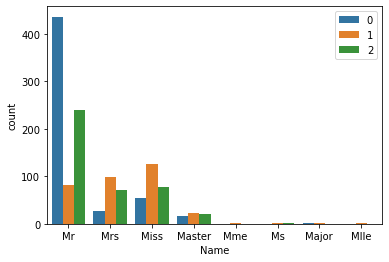

In [515]:
sns.countplot(x='Name', hue='Survived', data=df)
plt.legend(loc='upper right')

It seems Mr vs the rest has a different behaviour against the target.

In [516]:
df['Name'][df.Name!='Mr'] = 'Other'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


##### 2) Siblings

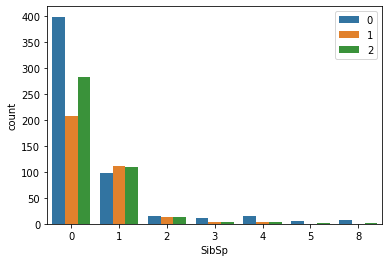

In [517]:
sns.countplot(x='SibSp', hue='Survived', data=df)
plt.legend(loc='upper right')

In [518]:
#It seems that 1 sibling makes the difference
df['SibSp'][df['SibSp']!=1] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### 3) Parch

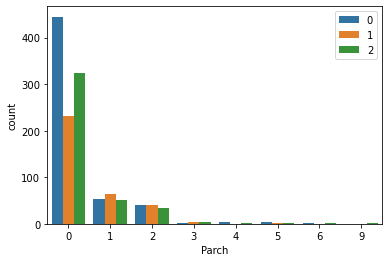

In [519]:
sns.countplot(x='Parch', hue='Survived', data=df)
plt.legend(loc='upper right')

In [520]:
df['Parch2'] = 0
df['Parch2'][df['Parch']!=0] = 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### 4) Ticket

In [521]:
df2 = pd.DataFrame({'Ticketdigit': df.Ticket.str[0].str.isdigit(), 'Survived': df.Survived})

C:\Users\Prueba\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Ticketdigit', ylabel='count'>

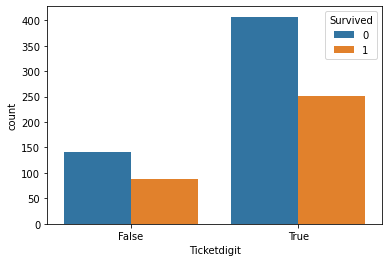

In [522]:
#Check if the tickets starting by a digit had a different survival rate
sns.countplot('Ticketdigit', hue='Survived', data=df2[df2.Survived!=2])

In [523]:
#Check if the first letter of the ticket matters
df3 = df[['Ticket', 'Survived']][df.Ticket.str[0].str.isalpha()]
df3['Ticket'] = df3.Ticket.str[0]

C:\Users\Prueba\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Ticket', ylabel='count'>

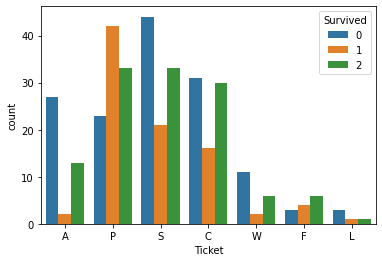

In [524]:
sns.countplot('Ticket', hue='Survived', data=df3)

It seems that A and P letters matter.

In [525]:
df['Ticket2'] = df.Ticket.str.extract(r'(\d{3,5})')

In [526]:
df['Ticket2'].fillna('0', inplace=True)
df['Ticket2']=df['Ticket2'].astype('int')
df['Ticket2'][df.Ticket2==0] = np.nan

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='Ticket2', ylabel='Density'>

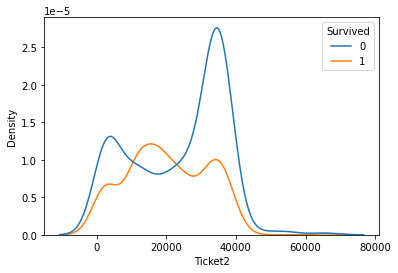

In [527]:
sns.kdeplot('Ticket2', hue='Survived', data=df[df.Survived!=2])

In [528]:
X = df.drop(['Cabin', 'Ticket'], axis=1)
X = pd.get_dummies(X)
imp = MissForest()
X_1 = imp.fit_transform(X)

Iteration: 0
Iteration: 1
Iteration: 2


In [529]:
X_1 = pd.DataFrame(X_1, columns=X.columns)
X_1.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Parch2,Ticket2,Name_Mr,Name_Other,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,21171.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,17599.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,31012.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,11380.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,37345.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [530]:
df['Ticket2'] = X_1['Ticket2'].values

In [531]:
df['Ticket'][df.Ticket.str[0] == 'A'] = 'A'
df['Ticket'][df.Ticket.str[0] == 'P'] = 'P'
df['Ticket'][(df.Ticket != 'A')& (df.Ticket != 'P')] = 'Other'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so w

In [532]:
df.Ticket.isna().sum()

0

In [533]:
df.Ticket.value_counts()

Other    1167
P          98
A          42
Name: Ticket, dtype: int64

##### 5) Cabin

C:\Users\Prueba\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Cabin', ylabel='count'>

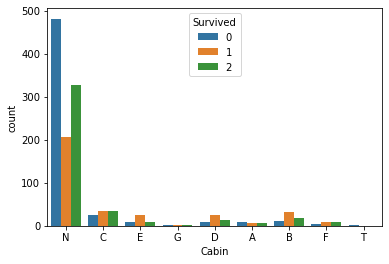

In [534]:
df['Cabin'] = df.Cabin.str[0]
sns.countplot('Cabin', hue='Survived', data=df)

NA vs the rest seems ok

In [535]:
df.Cabin[df.Cabin!='N'] = 'O'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


C:\Users\Prueba\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Cabin', ylabel='count'>

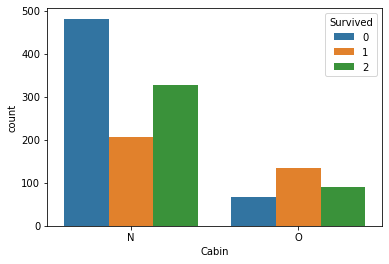

In [536]:
sns.countplot('Cabin', hue='Survived', data=df)

##### 6) Fare

<AxesSubplot:xlabel='Fare', ylabel='Density'>

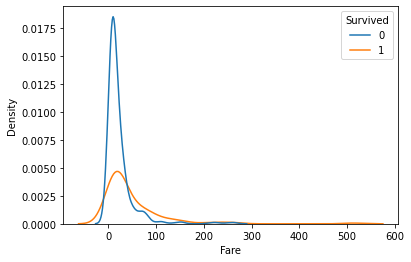

In [537]:
sns.kdeplot('Fare', hue='Survived', data=df[df.Survived!=2])

##### 7) Embarked

<AxesSubplot:xlabel='Embarked', ylabel='count'>

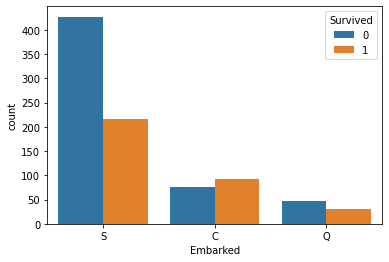

In [538]:
sns.countplot(x='Embarked',hue='Survived', data=df[df.Survived!=2] )

In [539]:
df['Embarked'][df.Embarked=='Q'] = "S"

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [540]:
df.to_pickle("treated_dataset.pkl")